In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    HyperparameterTuner,
)

from src import fetch_bucketed_from_bitmex, preprocess, train, evaluate

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

# Feature Engineering

In [3]:
preprocess(df, input_dir)

# Training

### Benchmark: Linear Model

In [2]:
train(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    checkpoint_path=None,
    # checkpoint_path='cache_output/checkpoint.pth',
    model_class="linear",
    seq_len= 19,
    hidden_dim= 256,
    n_epochs= 16,
    batch_size= 1024,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 1.798e-01 | 1.533e-03 |      0 |
|     1 | 5.200e-03 | 2.365e-03 |      0 |
|     2 | 4.313e-03 | 1.937e-03 |      0 |
|     3 | 3.751e-03 | 1.652e-03 |      0 |
|     4 | 3.313e-03 | 1.342e-03 |      0 |
|     5 | 3.268e-03 | 1.339e-03 |      0 |
|     6 | 3.224e-03 | 1.322e-03 |      0 |
|     7 | 3.177e-03 | 1.299e-03 |      0 |
|     8 | 3.128e-03 | 1.260e-03 |      0 |
|     9 | 3.123e-03 | 1.256e-03 |      0 |
|    10 | 3.117e-03 | 1.253e-03 |      0 |
|    11 | 3.110e-03 | 1.251e-03 |      0 |
|    12 | 3.104e-03 | 1.249e-03 |      0 |
|    13 | 3.103e-03 | 1.248e-03 |      0 |
|    14 | 3.102e-03 | 1.247e-03 |      0 |
|    15 | 3.101e-03 | 1.246e-03 |      0 |
loss of trai is 3.100e-03
loss of vali is 1.246e-03


### Solution: LSTM Model

In [3]:
inputs = sagemaker_session.upload_data(
    path=input_dir, bucket=bucket, key_prefix="lstm-trader"
)

estimator = PyTorch(
    source_dir="src",
    entry_point="trainer.py",
    hyperparameters={
        "seq-len": 19,
        "hidden-dim": 256,
        "n-epochs": 16,
        "batch-size": 1024,
    },
    framework_version="1.2.0",
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
)

estimator.fit({"data_dir": inputs})

2020-01-06 07:09:40 Starting - Starting the training job...
2020-01-06 07:09:42 Starting - Launching requested ML instances......
2020-01-06 07:10:50 Starting - Preparing the instances for training.........
2020-01-06 07:12:35 Downloading - Downloading input data...
2020-01-06 07:12:56 Training - Downloading the training image............
2020-01-06 07:14:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-06 07:14:59,587 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-06 07:14:59,612 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-06 07:14:59,613 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-06 07:14:59,872 sagemaker-containers INFO     Module trainer does not provide a setup.py. 
Generating setup.py
2020-01-06 07:14:5

In [3]:
# tuner = HyperparameterTuner(
#     estimator,
#     objective_metric_name="validation loss",
#     hyperparameter_ranges={
#         "seq-len": IntegerParameter(8, 256),
#         "hidden-dim": IntegerParameter(8, 128),
#     },
#     metric_definitions=[
#         {"Name": "validation loss", "Regex": "loss of vali is ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+))"}
#     ],
#     max_jobs=16,
#     max_parallel_jobs=1,
#     objective_type="Minimize",
# )

# tuner.fit({"data_dir": inputs})

In [4]:
sagemaker_session.download_data(
    path=model_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/model.tar.gz",
)
!tar xvf cache_model/model.tar.gz --directory=cache_model

lstm.pth


# Evaluation

trai  linear  3.100151e-03
trai    lstm  9.760915e-05
vali  linear  1.246236e-03
vali    lstm  1.820372e-04
test  linear  1.002098e-03
test    lstm  2.966555e-03


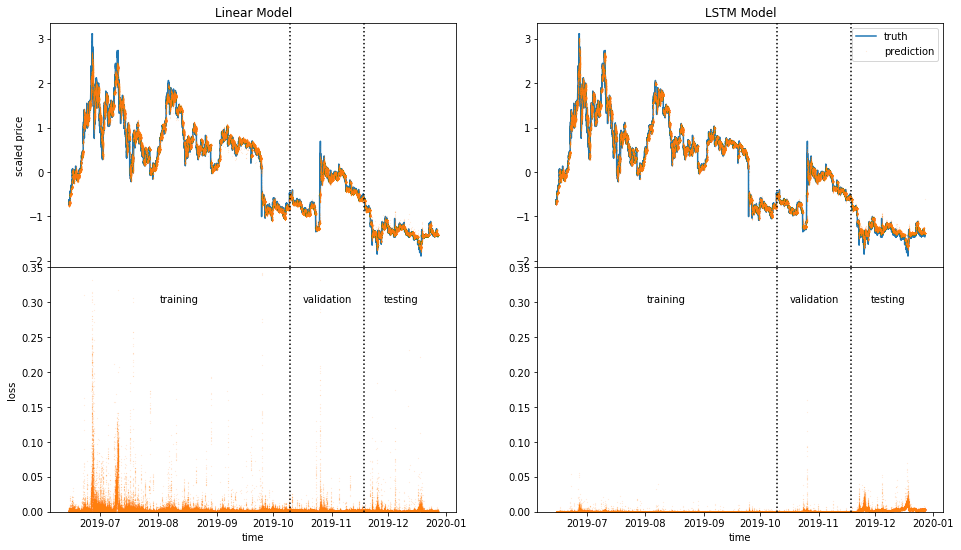

In [35]:
evaluate(input_dir, model_dir, seq_len=19)